# Example notebook

In [1]:
import perfume
import perfume.analyze
import pandas as pd
import bokeh.io
bokeh.io.output_notebook()

Loading BokehJS ...

## Setup

To start, set up some functions to benchmark.

In [2]:
import time
import numpy as np

def test_fn_1():
    good = np.random.poisson(20)
    bad = np.random.poisson(100)
    msec = np.random.choice([good, bad], p=[.99, .01])
    time.sleep(msec / 3000.)

def test_fn_1_no_outliers():
    time.sleep(np.random.poisson(20) / 3000.)

def test_fn_2():
    good = np.random.poisson(5)
    bad = np.random.poisson(150)
    msec = np.random.choice([good, bad], p=[.95, .05])
    time.sleep(msec / 3000.)

def test_fn_3():
    msec = max(1, np.random.normal(100, 10))
    time.sleep(msec / 3000.)

numbers = np.arange(0, 1, 1. / (3 * 5000000))

def test_fn_4():
    return np.sum(numbers)

# Create a variable named "samples", in this cell.  This way,
# if we change these functions, we'll reset the samples so we
# don't use old data with changed implementations.
samples = None

## Benchmark

Run the benchmark for a while by executing this cell.  Since we capture the output data in `samples`, and pass it back in as an argument, you can interrupt the cell, take a look at the output so far, and then execute this cell again to resume the benchmark.

In [3]:
samples = perfume.bench(test_fn_1, test_fn_2, test_fn_3, test_fn_4,
                        samples=samples)

## Analyzing the samples

Let's look at the format of the output, each function execution gets its begin and end time recorded:

In [4]:
samples.head()

function     test_fn_1                   test_fn_2                \
timing           begin           end         begin           end   
0         5.963691e+07  5.963692e+07  5.963692e+07  5.963692e+07   
1         5.963696e+07  5.963697e+07  5.963697e+07  5.963697e+07   
2         5.963701e+07  5.963702e+07  5.963702e+07  5.963702e+07   
3         5.963706e+07  5.963707e+07  5.963707e+07  5.963707e+07   
4         5.963711e+07  5.963712e+07  5.963712e+07  5.963712e+07   

function     test_fn_3                   test_fn_4                
timing           begin           end         begin           end  
0         5.963692e+07  5.963695e+07  5.963695e+07  5.963696e+07  
1         5.963697e+07  5.963700e+07  5.963700e+07  5.963701e+07  
2         5.963702e+07  5.963705e+07  5.963705e+07  5.963706e+07  
3         5.963707e+07  5.963710e+07  5.963710e+07  5.963711e+07  
4         5.963712e+07  5.963715e+07  5.963715e+07  5.963716e+07

One thing we can do is plot each function's distribution as it develops over simulated time:

In [5]:
perfume.analyze.cumulative_quantiles_plot(samples)

We can run a K-S test and see whether our functions are significantly different:

In [6]:
perfume.analyze.ks_test(perfume.analyze.timings(samples))

,test_fn_2,test_fn_3,test_fn_4
K-S test Z,,,
test_fn_1,8.53815,9.486833,8.854377
test_fn_2,NaN,8.854377,8.854377
test_fn_3,NaN,NaN,9.486833


We can convert them to elapsed timings intsead of begin/end time points, get resampled timings to see outliers show a stronger presence, or isolate samples to be as if they ran by themselves

In [7]:
timings = perfume.analyze.timings(samples)
bt = perfume.analyze.bucket_resample_timings(samples)
isolated = perfume.analyze.isolate(samples)
isolated.head()

function  test_fn_1            test_fn_2             test_fn_3              \
timing        begin        end     begin       end       begin         end   
0          0.000000   4.646214  0.000000  3.590106    0.000000   30.266184   
1          4.646214  11.608025  3.590106  4.864995   30.266184   59.953504   
2         11.608025  19.251391  4.864995  5.815610   59.953504   91.075341   
3         19.251391  27.206830  5.815610  8.099528   91.075341  126.591262   
4         27.206830  33.773187  8.099528  9.654849  126.591262  155.066704   

function  test_fn_4             
timing        begin        end  
0          0.000000   9.468090  
1          9.468090  19.624864  
2         19.624864  28.918829  
3         28.918829  38.908533  
4         38.908533  48.951759

With these, and other charting libraries, you can do whatever you want with the data:

function,test_fn_1,test_fn_2,test_fn_3,test_fn_4
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.868079,5.468960,33.313603,14.125864
std,0.461578,4.100255,0.985487,0.659526
min,5.360584,1.152594,29.722022,11.727401
25%,6.552711,1.982938,32.653076,13.697427
50%,6.860023,6.382206,33.316857,14.149098
75%,7.173977,7.366286,33.980545,14.576568
max,8.679657,28.873607,37.210863,16.655513


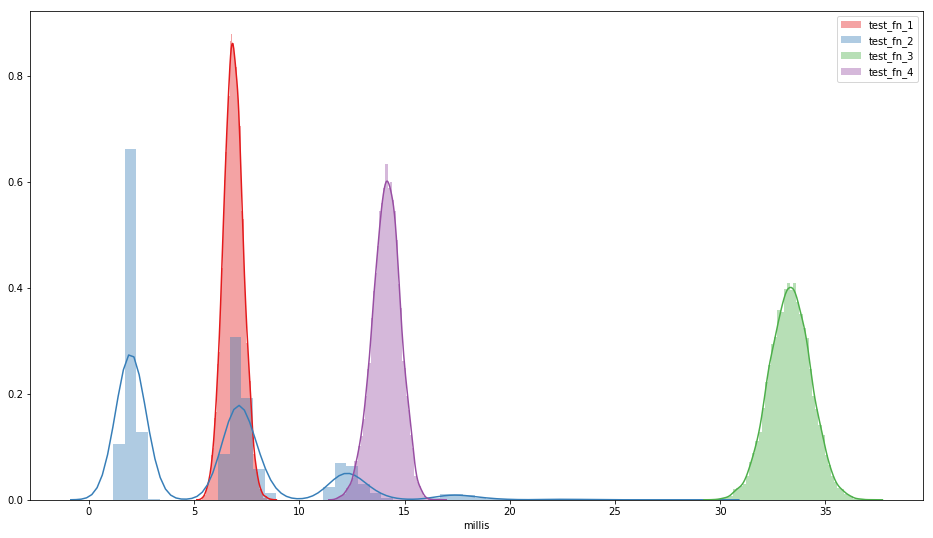

In [8]:
from bokeh import palettes
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

timings = perfume.analyze.bucket_resample_timings(samples, sample_count=10000)
fig, ax = plt.subplots(figsize=(16, 9))
for col, color in zip(timings.columns, palettes.Set1[len(timings.columns)]):
    sns.distplot(timings[col], label=col, color=color, ax=ax,
#                  hist_kws=dict(cumulative=True),
#                  kde_kws=dict(cumulative=True)
                )
ax.set_xlabel('millis')
ax.legend()
timings.describe()

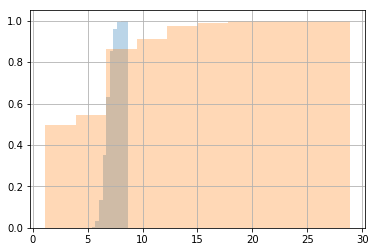

In [9]:
import matplotlib.pyplot as plt
timings['test_fn_1'].hist(cumulative=True, normed=1, alpha=0.3)
timings['test_fn_2'].hist(cumulative=True, normed=1, alpha=0.3)

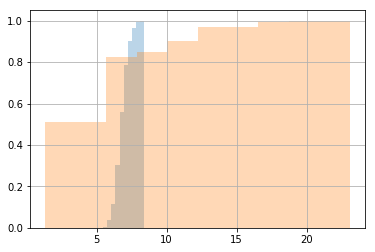

In [10]:
import matplotlib.pyplot as plt
bt['test_fn_1'].hist(cumulative=True, normed=1, alpha=0.3)
bt['test_fn_2'].hist(cumulative=True, normed=1, alpha=0.3)

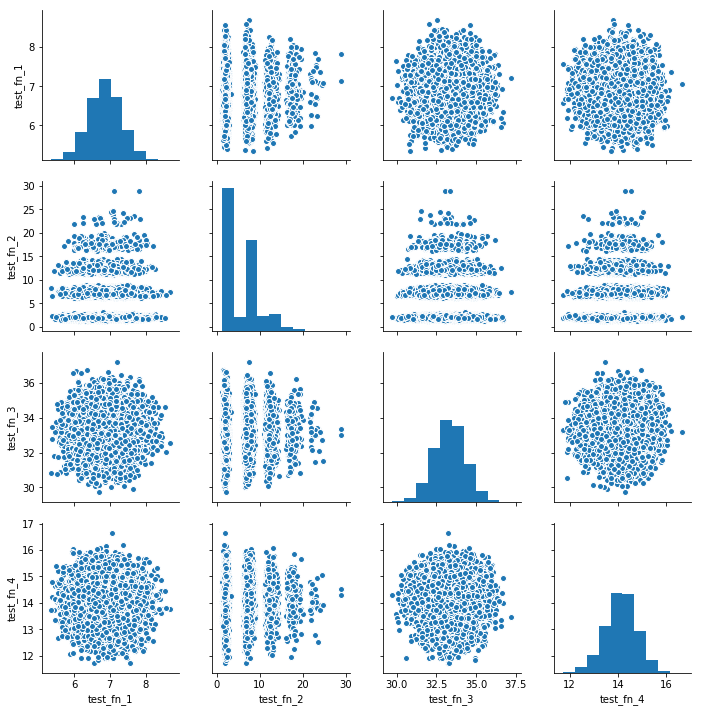

In [11]:
sns.pairplot(timings#, diag_kws={'cumulative': True}
            )

In [12]:
import scipy.stats
bt = perfume.analyze.bucket_resample_timings(samples)
(scipy.stats.ks_2samp(timings['test_fn_1'], timings['test_fn_2']),
 scipy.stats.ks_2samp(bt['test_fn_1'], bt['test_fn_2']))

(Ks_2sampResult(statistic=0.4975, pvalue=0.0),
 Ks_2sampResult(statistic=0.499, pvalue=8.9050323239739814e-110))